# Lineage tracing data analysis

Cellular lineages are ubiquitious in biology. Perhaps the most famous example is that of embyrogenesis: the process by which an organism like a human being is generated from from a single cell, the fertilized egg. During this process, subsequent cell divisions give rise to daughter cells and over time entire "lineages" that can take on specialized roles within the developing embryo. The amazing complexity of this process has captured the imagination of scientists for centuries, and over the past century and a half our understanding of this process has been bolstered by the development of high-throughput sequencing assays and new "lineage tracing" technologies for visualizing and characterizing this process {cite}`Woodworth2017`. Amongst the most exciting of these methods allow investigators to link measurements of cell state with models of their history, thus providing a window into how differentiation trajectories might have unfolded.

The marriage of single-cell assays and lineage tracing approaches has yielded an exponential growth in the complexity of datasets, requiring the development of new computational methodology for their analysis. As such, there has been a strong need in developing new computational methodology for processing these datasets {cite}`DreamChallenge`. Sourcing heavily from population genetics literature, the past half decade has witnessed an exciting confluence of traditional concepts in evolutionary biology with cutting-edge genome engineering techniques.     

In this chapter, we provide a brief overview of these new technologies and focus on the available computational pipelines for the analysis of their output and extraction of biological insight. To note, the pay special focus with our example to the CRISPR/Cas9-based "evolving" lineage tracing setting. However, there exist several other greatly useful experimental alternatives; for a more complete view, we refer the interested reader to the excellent reviews by Wagner & Klein {cite}`wagner2020`, Mckenna & Gagnon {cite}`mckenna`, and VanHorn & Morris {cite}`VanHorn2021`.

## Lineage tracing technologies

The goal of lineage tracing techniques is to infer lineage, or ancestry relationships between observed cells. In this, there are two major variables to consider: scale and resolution. Classical approaches relied heavily on visual observation: for example, in the 1970s Sulston and colleagues derived the first developmental lineage of the nematode _C. elegans_ by meticulously watching cell divisions under a microscope {cite}`Sulston1973`. While playing an imperative role in the progression of the field, such approaches cannot scale to complex organisms with more stochastic developmental lineages.

Over the past two decades, the development of revolutionary sequencing assays and microfluidic devices has contributed to the development of new and diverse lineage tracing methodology. To digest the plethora of techniques, it is helpful to classify approaches as "_prospective_" or "_retrospective_". Generally speaking, prospective lineage tracing approaches use a heritable marker to trace a clonal population (i.e., all the descendants of a single cell). On the other hand, retrospective lineage tracing approaches use variability amongst observed cells - such as naturally occuring genetic mutations - to infer a model of their lineage, or "_phylogeny_", summarizing the cell division history of a clonal population.

Several approaches have been developed for prospectively tracing a clonal population: for example, recombinases under a tissue-specific promoter can be used to activate fluorscent markers that act as heritable marks for a specific tissue lineage {cite}`brainbow`. Alternatively, lentiviral transduction can be used to integrate random DNA barcodes into cellular genomes to provide a heritable mark that can be used to deconvovle clonal identities with a sequencing readout. Though these approaches are highly scalable and often do not require heavy genome engineering, they can only report properties at the clonal-level such as clone size and composition.
Retrospective lineage tracers overcome these limitations and provide an additional advantage over prospective tracers in that they can only report properties at the clonal-level such as clone size and composition, and are restricted to systems that are accessible to genome engineering. Traditionally, this has been done by leveraging natural genetic variation between cells to reconstruct a cell division history. While this approach is still widely and successfully used to study human tumors or tissue developmental histories, experimentalists have little or no control over how often or where mutations occur. In experimental models, there are opportunities to recapitulate the advantages of retrospective tracers while improving on the caveats by engineering evolvable lineage tracers. Such evolving tracers typically consist of engineering cells with a "scratchpad" (or, synonymously, "target site") that can acquire mutations. For example, a popular approach that this chapter focuses on uses Cas9 to introduce insertions and deletions (i.e., "indels") at the target site. In this way, cellular lineages acquire heritable mutations over time that can be subsequently read out with high-throughput sequencing platforms and used to infer phylogenies representing a model of the cell lineage.

To note, both classes of lineage-tracing approaches can take advantage of adjacent advances in single-cell multiomic profiling. For example, investigators have routinely used single-cell RNA-seq (scRNA-seq) to read out simultaneously the functional state of single cells and their lineage relationships. This multimodal readout has created opportunity for new computational methodologies, which we detail below. 

As stated above, in this chapter we provide a detailed walkthrough on the analysis of data from evolving CRISPR/Cas9-based lineage tracers.

\ZP{should we (i) add more citations\useful references here along text? 
(ii) at the end refer to CoSpar \ LARRY for examples in different setting?}

-- \MJ{Definitely! I need to go through and add more references. We can add LARRY here as it is a technology; CoSpar might be better fit for your section}

## Overview of evolving lineage tracing data analysis pipelines

Before delving into the analysis of our example dataset, we will provide an overview of the computational pipeline for the analysis of data generated by evolving tracers. In general, with these systems, analysis will begin with raw sequencing data of an _amplicon_ library of target sites (often derived from a conventional scRNA-seq platform like 10X Chromium). Depending on the technology at hand, each sequenced amplicon will be between 150-300bp long; in the case of CRISPR/Cas9-based evolving tracers, each read will contain one more Cas9 cut sites. Within the preprocessing of this data, anlaysts are tasked with aligning the reads to a reference sequence and identifying any mutations (e.g., indels). 

While the preprocessing of these datasets is a critical step, in the interest of space, we focus on analysis pipelines  that receive preprocessed sequencing data as input and refer the reader to an external preprocessing tutorial which can be found here: https://cassiopeia-lineage.readthedocs.io/en/latest/notebooks/preprocess.html.  

In most analysis frameworks, the preprocessing of the raw sequencing reads produces a data structure called the **character matrix** (denoted by $\chi$) that summarizes the observed mutations in each cell across the target sites. In this data structure, each row is a cell (or "sample"), each column is a target site (or "character"), and the (row, column) values are categorical variables representing the identity of the indel observed in that cell at that particular cut site (or "character-state"). Depending on the technology at hand, these character matrices can report on anywhere between 100 and 10,000 samples across up to 100 characters.

At this point, this data structure abstracts away the technicalities of the evolving lineage tracing assay and opens up the opportunity to computationally infer a **phylogenetic tree** ($\mathcal{T}$) over the cells. Specifically, the goal is to learn a hierarchical tree structure over each of the cells in $\chi$ (our character matrix). In this tree, each node represents a sample and each edge represents a lineage relationship. Importantly, we often have only observed the _leaves_ (denoted by $\mathcal{L}$) of the tree and we refer to any of the unobserved set of internal nodes as _ancestral_ nodes.

There are many algorithmic choices for inferring the phylogenetic tree ($\mathcal{T}$) from the character matrix $\chi$, which can be generally broken up into "character-based" and "distance-based" approaches:
- Character-based: perform a combinatorial search through all possible tree topologies while seeking to optimize a function over the characters (e.g., the likelihood of the evolutionary history given the mutations observed in the characters). 
- distance-based (e.g Neighbor-Joining): use a notion of cell-cell distances (denoted by $\delta$) to infer a phylogenetic tree and typically run in polynomial time. While distance-based approaches can perform much faster, they require one to iteratively find the best cell-cell dissimilarity function which can be equally time consuming.

Following phylogenetic tree reconstruction, there are several options for downstream analysis. For example, one can learn about the rates of cell state changes across the developmental history or the relative propensities of cells to divide in a population. Below, we will demonstrate via code examples across two major case studies how these different components fit together to gain fundamental insights into the dynamic processes underlying cellular lineages.

\ZP{consider the necessity of defining $\mathcal{T}$, $\chi$, $\delta$}

## Environment setup.

In this tutorial, we will primarily make use of the `Cassiopeia` package {cite}`Jones2020` for lineage tracing analysis.

Before we enter this notebook's analysis, let's set up our environmnet.

In [22]:
import cassiopeia as cas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

<div class="alert alert-block alert-warning" style="color:black;">
<b>Heads up!</b> 
<br/br>
    You should be sure to have python3.7 or above installed to follow this tutorial. Also, if you haven't yet, you can install Cassiopeia by following the instructions on <a href="https://github.com/Yoseflab/Cassiopeia">the Cassiopeia github page</a>.
</div>


# Case Study: Tracing tumor development in a mouse model of lung cancer
In this case study, we will make use of the recent study presented in {cite}`Yang2022`. Briefly, in this study the authors integrated a evolving CRISPR/Cas9-based lineage tracer into the KP mouse model of non-small-cell lung cancer {cite}`DuPage`. Specifically, this mouse model carries oncogenic _Kras_ and _Tp53_ mutations that under native conditions are not expressed. However, upon the introduction of Cre recombinase via lentiviral inhalation, these oncogenic mutations are activated in single cells of the lung airway epithelium inducing tumors. In this study, the CRISPR/Cas9-based lineage tracer is under similar control and thus becomes active simultaneously upon tumor induction.

With this system, the authors followed tumors from their single-cell origins over the course of approximately 4.5-6 months at which point they harvested aggressive, metastatic tumors. After dissociation of the tumors, the authors profiled both the lineage tracing target sites and the RNA content of single cells. This resulted in a large dataset of more than 70,000 cells across more than 100 tumors with both lineage and scRNA-seq information.

In this tutorial, we will demonstrate how a user can take processed target site data to learn interesting dynamic properties of lineages. Throughout this case study, each lineage will correspond to a single primary tumor sampled from a mouse lung. 

## Downloading the data
This data is publicly hosted on [Zenodo](https://zenodo.org/record/5847462#.YrFDKuzMI6A) and we can download the data as follows:

In [9]:
!wget https://zenodo.org/record/5847462/files/KPTracer-Data.tar.gz?download=1

--2022-06-20 21:18:55--  https://zenodo.org/record/5847462/files/KPTracer-Data.tar.gz?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1304975216 (1.2G) [application/octet-stream]
Saving to: ‘KPTracer-Data.tar.gz?download=1’

KPTracer-Data.tar.g 100%[===================>]   1.21G  8.21MB/s    in 3m 54s  

2022-06-20 21:22:51 (5.32 MB/s) - ‘KPTracer-Data.tar.gz?download=1’ saved [1304975216/1304975216]



In [12]:
!tar -xvzf KPTracer-Data.tar.gz?download=1

KPTracer-Data/
KPTracer-Data/plasticity_scores.tsv
KPTracer-Data/._.DS_Store
KPTracer-Data/.DS_Store
KPTracer-Data/trees/
KPTracer-Data/._trcr_master.txt
KPTracer-Data/trcr_master.txt
KPTracer-Data/._README
KPTracer-Data/README
KPTracer-Data/fitnesses/
KPTracer-Data/KPTracer.alleleTable.unfiltered.txt
KPTracer-Data/KPTracer.alleleTable.FINAL.txt
KPTracer-Data/expression/
KPTracer-Data/expansions/
KPTracer-Data/tumor_statistics.tsv
KPTracer-Data/KPTracer_meta.csv
KPTracer-Data/expansions/clonal_expansions.3777_Apc_T4.txt
KPTracer-Data/expansions/clonal_expansions.3513_NT_T3.nj.txt
KPTracer-Data/expansions/clonal_expansions.3703_NT_T2.nj.txt
KPTracer-Data/expansions/clonal_expansions.3457_Apc_T5.txt
KPTracer-Data/expansions/clonal_expansions.3457_Apc_T4.txt
KPTracer-Data/expansions/clonal_expansions.3724_NT_T1.txt
KPTracer-Data/expansions/clonal_expansions.3435_NT_T4.nj.txt
KPTracer-Data/expansions/clonal_expansions.3777_Apc_T5.txt
KPTracer-Data/expansions/clonal_expansions.3730_NT_T1.tx

## Examine the data

The processed lineage tracing data is stored in an `allele_table` which summarizes the edits across each target site Cas9 cut site on each intBC of a cell.

Columns labeled `r*` indicate cut sites and store the indel CIGAR string for each intBC in each cellBC. The table can also store meta data corresponding to the tumor assignment for each cell.

We'll focus on the data from KP tumors without any additional perturbations.

In [14]:
allele_table = pd.read_csv("KPTracer-Data/KPTracer.alleleTable.FINAL.txt", sep='\t', index_col = 0)

allele_table.head(5)

/data/yosef2/users/mattjones/opt/miniconda3/envs/cas3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3186: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cellBC,intBC,r1,r2,r3,allele,sampleID,UMI,readCount,Tumor,MetFamily,ES_clone
0,L9.TTTGTCATCTGTCAAG-1,TTCCCTATTTGCTA,CGCCG[111:2D]AAATG,GATAT[None]CTCTG,AATTC[220:1I]GGCGGA,CGCCG[111:2D]AAATGGATAT[None]CTCTGAATTC[220:1I...,L9,54,796,3724_NT_T1,3724_NT_T1,2E1
1,L9.TTTGTCATCTGTCAAG-1,TGTTTTTGTCTGCA,CGCCG[111:1I]AAAAAA,CATGT[151:19D]TGGTT,TTAAT[218:2D]GCGGA,CGCCG[111:1I]AAAAAACATGT[151:19D]TGGTTTTAAT[21...,L9,13,209,3724_NT_T1,3724_NT_T1,2E1
2,L9.TTTGTCATCTGTCAAG-1,TGTGAAGGTCAATA,CCGAA[113:49D]GATAT,CCGAA[113:49D]GATAT,AATTC[220:5D]GGACA,CCGAA[113:49D]GATATCCGAA[113:49D]GATATAATTC[22...,L9,68,1193,3724_NT_T1,3724_NT_T1,2E1
3,L9.TTTGTCATCTGTCAAG-1,TCAGGCGATGCGAA,CGCCG[111:1I]AAAAAA,CGATA[166:1I]TTCTCT,TAATT[219:2D]CGGAG,CGCCG[111:1I]AAAAAACGATA[166:1I]TTCTCTTAATT[21...,L9,43,745,3724_NT_T1,3724_NT_T1,2E1
4,L9.TTTGTCATCTGTCAAG-1,TATGATTAGTCGCG,CGCCG[111:1D]AAAAT,GATAT[167:54D]CGGAG,GATAT[167:54D]CGGAG,CGCCG[111:1D]AAAATGATAT[167:54D]CGGAGGATAT[167...,L9,27,530,3724_NT_T1,3724_NT_T1,2E1


In [19]:
all_tumors = allele_table['Tumor'].unique()
primary_nt_tumors = [tumor for tumor in all_tumors if 'NT' in tumor and tumor.split("_")[2].startswith("T")]

primary_nt_allele_table = allele_table[allele_table['Tumor'].isin(primary_nt_tumors)]

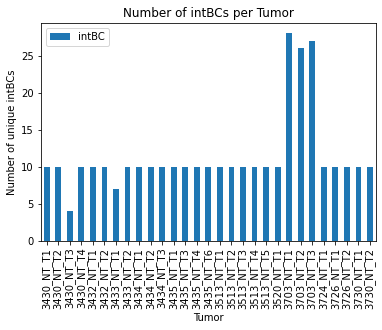

In [23]:
primary_nt_allele_table.groupby(['Tumor']).agg({"intBC": 'nunique'}).plot(kind='bar')
plt.ylabel("Number of unique intBCs")
plt.title("Number of intBCs per Tumor")
plt.show()

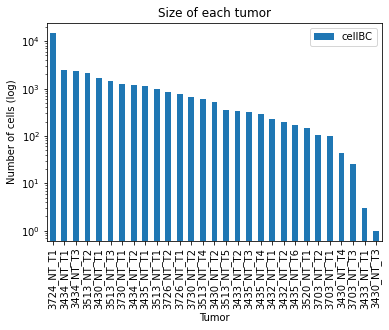

In [27]:
primary_nt_allele_table.groupby(['Tumor']).agg({"cellBC": 'nunique'}).sort_values(by = 'cellBC', ascending=False).plot(kind='bar')
plt.yscale('log')
plt.ylabel("Number of cells (log)")
plt.title("Size of each tumor")
plt.show()

## Preparing the data for lineage reconstruction

Before reconstructing lineages, we'll estimate indel priors.

In order to reconstruct lineages, we'll have to convert the allele table for a particular tumor into a "character matrix". As defined above, these data structures summarize the mutations observed in each target site in each cell.

In [30]:
indel_priors = cas.pp.compute_empirical_indel_priors(allele_table, grouping_variables=['intBC', 'MetFamily'])

indel_priors.sort_values(by='count', ascending=False).head()

,count,freq
indel,,
TAATT[219:2D]CGGAG,664.0,0.764977
CGCCG[111:1I]AAAAAA,584.0,0.672811
CGCCG[111:1D]AAAAT,504.0,0.580645
CGCCG[111:2D]AAATG,401.0,0.461982
AATTC[220:3D]GAGGA,395.0,0.455069


In [35]:
tumor = '3726_NT_T1'

tumor_allele_table = primary_nt_allele_table[primary_nt_allele_table['Tumor'] == tumor]

n_cells = tumor_allele_table['cellBC'].nunique()
n_intbc = tumor_allele_table['intBC'].nunique()

print(f"Tumor population {tumor} has {n_cells} cells and {n_intbc} intBCs ({n_intbc * 3}) characters.")

Tumor population 3726_NT_T1 has 772 cells and 10 intBCs (30) characters.


In [37]:
(character_matrix, priors, state_to_indel) = \ 
        cas.pp.convert_alleletable_to_character_matrix(tumor_allele_table,
                                                      allele_rep_thresh = 0.9, 
                                                      mutation_priors=indel_prior)

character_matrix.head(5)

Dropping the following intBCs due to lack of diversity with threshold 0.9: ['ACTCTGCTCCAGATr2', 'ACTCTGCTCCAGATr3', 'GCCTACTTAAGTCCr1', 'GTTTATTTCCGTATr3', 'TATGATTAGTCGCGr1', 'TATGATTAGTCGCGr2', 'TGATATAAATCTTTr2', 'TTCCCTATTTGCTAr2', 'TGTTTTTGTCTGCAr1', 'ACAGGTGCTCAAATr1', 'ACAGGTGCTCAAATr2', 'ACAGGTGCTCAAATr3']


Processing characters:   0%|          | 0/18 [00:00<?, ?it/s]

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13,r14,r15,r16,r17,r18
L6.TTTGTCACACATCCAA-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-1,-1
L6.TTTGGTTTCTGAGTGT-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
L6.TTTGGTTCATGTAAGA-1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
L6.TTTGCGCAGCTCCTCT-1,1,2,3,3,3,3,1,3,3,3,1,1,3,3,3,3,3,0
L6.TTTATGCTCGCCGTGA-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,0


## Reconstructing the lineage

In [41]:
greedy_tree = cas.data.CassiopeiaTree(character_matrix=character_matrix, priors=priors)
neighbor_joining_tree = cas.data.CassiopeiaTree(character_matrix=character_matrix, priors=priors)

In [42]:
greedy_solver = cas.solver.VanillaGreedySolver()
neighbor_joining_solver = cas.solver.NeighborJoiningSolver(add_root=True)

filling in multiindex table:   0%|          | 0/6432 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.39it/s]


(<Figure size 504x504 with 1 Axes>, <AxesSubplot:>)

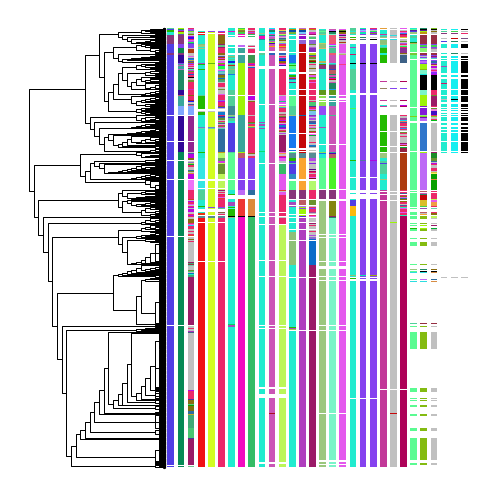

In [43]:
greedy_solver.solve(greedy_tree)

cas.pl.plot_matplotlib(greedy_tree, orient='right', allele_table=tumor_allele_table)

filling in multiindex table:   0%|          | 0/6432 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  9.40it/s]


(<Figure size 504x504 with 1 Axes>, <AxesSubplot:>)

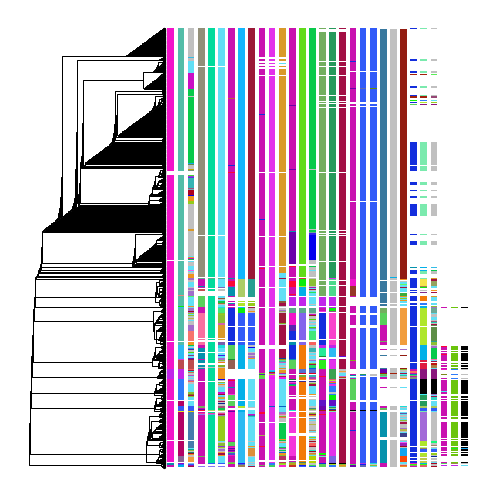

In [44]:
neighbor_joining_solver.solve(neighbor_joining_tree)

cas.pl.plot_matplotlib(neighbor_joining_tree, orient='right', allele_table=tumor_allele_table)

## Interpreting tree structure
We'll demonstrate useful approaches for quantifying interesting properties on trees (e.g., expansion, fitness)

## Learning from the tree
We'll discuss how one can integrate transcriptomic data to derive insights into evolutionary patterns. Topics to discuss are:

### Plasticity



### Coupling analysis

# Conclusions, more resources, future directions (Matt / Zoe)
First give an overview of the major applications of lineage tracing, review what we showed.

## Computational tools to interpret lineage tracing data

The increasing complexity of lineage tracing studies must be accompanied by computational methods which extend the analysis beyond the construction of phylogenetic trees. That is, methods that integrate multi-omics measurements with lineage tracing and temporal information to enable recovery of programs governing cell state, differentiation and behavior {cite}[`mukhopadhyay2022`](https://www.nature.com/articles/s41592-021-01370-6).

As this field is at its begining the number of available tools is still limited yet it is worth highlighting leading approaches: 
- LineageOT {cite}[`forrow2021`](https://www.nature.com/articles/s41467-021-25133-1): A general-purpose method for inferring developmental trajectories from scRNA-seq time courses equipped with lineage information each time point applicable for evolving CRISPR/Cas9-based setting. The method  was suggested as an extension of the Waddington OT {cite}[`schiebinger2019`](https://doi.org/10.1016/j.cell.2019.01.006) algorithm to take the lineage relationships into account when mapping cells from earlier to later time-points. When computing transition matrices across pairs of time-points, LineageOT corrects expression profiles in the later time-point based on their lineage similarity. For more details and tutorials we refer the reader to https://lineageot.readthedocs.io.
- CoSpar {cite}[`wang2022`](https://www.nature.com/articles/s41587-022-01209-1): A computational approach to infer cell dynamics from single-cell transcriptomics integrated with static barcoding lineage tracing data. The method relies on two basic assumptions on the nature of biological dynamics (i) cells in similar states behave similarly and (ii) cells limit their possible dynamics to give sparse transitions.  For more details and tutorials we refer the reader to https://cospar.readthedocs.io/.


## Benchmarking / Simulations (Matt)
Discuss tools for simulating lineage data for benchmarking new tools. Potentially discuss simulating transcriptome ontop of lineages too? (e.g., TedSim)

## Key takeaways (Matt & Zoe)

\ZP{maybe we should also refer to recent reviews which emphasize the power and strength of LT along with current limitations?, e.g. {cite}[`rodriguez2022`](https://doi.org/10.1242/dev.200877),{cite}[`mukhopadhyay2022`](https://www.nature.com/articles/s41592-021-01370-6) }